## The limit of geospatial sampling for modeling and uncertainty quantification

Purpose:     
             1. 
             2. 
             3. 
             Main method is ...

Modifications 
             1.

Author:      Jiong Wang
Created:     13/04/2024
Copyright:   (c) JonWang 2024
Licence:     <your licence> <MIT>

In [1]:
# import packages

import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import GPy

import rioxarray as rxr
import pandas as pd
import geopandas as gpd
import pickle

from mpl_toolkits.mplot3d import Axes3D  
from scipy import stats
from shapely.geometry import mapping, box
from scipy import interpolate
from scipy.stats.stats import pearsonr  


In [2]:
# plotting utility functions for visualizations


def plot_data(x, t):
    plt.scatter(x, t, marker='o', c="r", s=20)


def plot_truth(x, y, label='Truth'):
    plt.plot(x, y, 'k--', label=label)


def plot_predictive(x, y, std, y_label='Prediction', std_label='Uncertainty', plot_xy_labels=True):
    y = y.ravel()
    std = std.ravel()

    plt.plot(x, y, label=y_label)
    plt.fill_between(x.ravel(), y + std, y - std, alpha = 0.5, label=std_label)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
    plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='Post. samples')
    for i in range(1, ys.shape[1]):
        plt.plot(x, ys[:, i], 'r-', alpha=0.5)

    if plot_xy_labels:
        plt.xlabel('x')
        plt.ylabel('y')


def plot_posterior(mean, cov, w0, w1):
    resolution = 100

    grid_x = grid_y = np.linspace(-1, 1, resolution)
    grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

    densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(), cov=cov).reshape(resolution, resolution)
    plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
    plt.scatter(w0, w1, marker='x', c="r", s=20, label='Truth')

    plt.xlabel('w0')
    plt.ylabel('w1')


def print_comparison(title, a, b, a_prefix='np', b_prefix='br'):
    print(title)
    print('-' * len(title))
    print(f'{a_prefix}:', a)
    print(f'{b_prefix}:', b)
    print()

In [3]:
# Covariance/Kernel definition
def arbKer(var, l):
    # RBF form
    kernel = GPy.kern.RBF(input_dim=1, variance=var, lengthscale=l)
    return kernel


def priorGPclean(X, var, l, nsamp, show=True):
    # GP controlled noise drawn from a covariance matrix generated from kernel
    k1 = arbKer(var, l)
    k2 = arbKer(var, l)
    k = k1 + k2
    mu = np.zeros((len(X))) # vector of the means
    C = k.K(X,X) # covariance matrix
    
    Y = np.random.multivariate_normal(mu,C,nsamp)
    Y = np.transpose(Y)
    
    # Generate sample paths with mean mu and covariance C
    if show:
        pl.figure(figsize=(12.5,4)) # open new plotting window
        for i in range(nsamp):
            pl.plot(X[:],Y[:,i],'-')
        plt.xlim([-6., 11])
        plt.ylim([-15., 15.])
    return (Y)


### 01 Demonstration through simulated data

In [72]:
# Uncertainties of model fitting on random samples and random processes of fixed mean (0) and covariance

left,right = -5,15  # Data range

# Randomized parameter for simulated data
n_size = 10
var_true = 2.
len_true = 1.

# One simulated data 
X = np.linspace(left,right,500)[:,None]
ind = np.random.choice(len(X), n_size, replace=False)

# A predictor with pattern on indexed space, zero mean
Y = priorGPclean(X, var_true, len_true, nsamp=1, show=False)

# Sample from simulated data
X_N = X[ind]
Y_N = Y[ind]

# Model fit on samples
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=.2)  # Arbitrarily initialized covariance/kernel function
m = GPy.models.GPRegression(X_N,Y_N,k)  # Train/fit
m.constrain_positive('')
m.optimize()  # Optimization



Name : GP regression
Objective : 13.955969104935795
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    2.791442862475695  |      +ve      |        
  rbf.lengthscale          |   0.8898030817585768  |      +ve      |        
  Gaussian_noise.variance  |  0.00868005298698347  |      +ve      |        


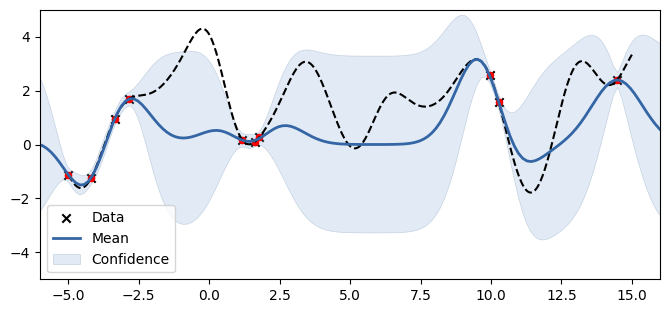

In [73]:
# Visualize fitted model on samples from the simulated data
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(X, Y, 'k--')
m.plot(ax=ax)
plot_data(X_N, Y_N)
plt.xlim([-6., 16.])
plt.ylim([-5., 5.])
print(m)


In [22]:
# Use existing simulated results

# Load stored results
uvxyz = np.load('500000run_equalspaced_randominit.npy')

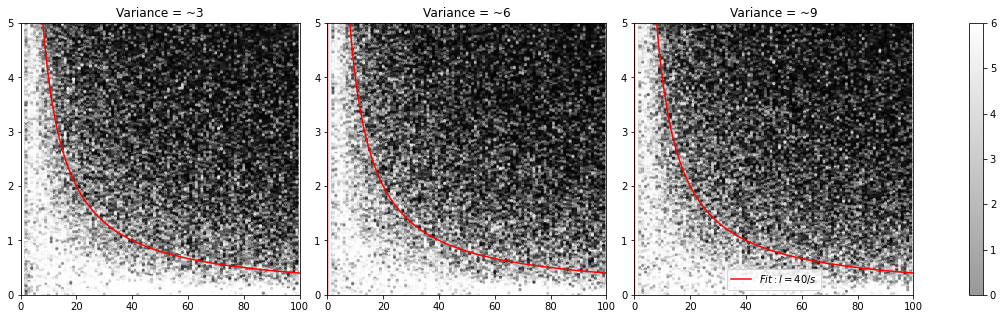

In [23]:
# Alternative visuals...
# The stored data is a stack of [var_t,var_est,len_t,len_est,sample_size]

var = np.linspace(0.,8.,4)  # VAR intervals

fig, axs = plt.subplots(1, 3, figsize=(20, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for i in range(len(var)-1):
    # Extract with lengthscale batches
    uvxyz_s = uvxyz[:,(uvxyz[0,:] > var[i]) & (uvxyz[0,:] < var[i+1])]  # a[ (-6<a[:,1]) & (a[:,1]<3) ]

    im=axs[i].scatter(uvxyz_s[4,:], uvxyz_s[2,:], s=10., marker='o', c=abs(uvxyz_s[2,:]-uvxyz_s[3,:]), vmin=0., vmax=6., cmap='gray', alpha=0.4, edgecolors='none')  #facecolor='b'
    axs[i].set_title('Variance = ~'+str((i+1)*3))
    axs[i].set_xlim([0., 100.])
    axs[i].set_ylim([0., 5.])
    #plt.colorbar(im,ax=axs[i])
    
    sample_num = np.linspace(-5.,105.,1000)[:,None] # reshape X to make it n*D, where D=1
    length_scale = 40./sample_num
    
    axs[i].plot(sample_num, length_scale, 'r-', mew=1.5, label=r'$Fit : l = 40/s$')
    
plt.colorbar(im, ax=axs.ravel().tolist())
plt.legend()

plt.savefig('08_nyquist.png', dpi=400)


### 02 Demonstration through 1D real-world data

In [4]:
# Read data
layer = 'LST_Day_1km'

lst = rxr.open_rasterio('lst_nl_20210718.tif', masked=True, variable=layer)
    # ('MYD11A1.A2019204.hdf', masked=True, variable=layer)

#plt.imshow(lst.values[0])  # lst.LST_Day_1km[0].values
print(lst.rio.crs)  # Print crs

# Read building data
blg = gpd.read_file('amsterdam.shp')

EPSG:32631


In [5]:
# A subset of LST covering Amsterdam

# Create bbox
geom = [box(*blg.total_bounds)]
bounds = gpd.GeoDataFrame(crs=blg.crs, geometry=geom)  # Make Geopandas dataframe
                                 
bounds_sin = bounds.to_crs(lst.rio.crs)  # Reproject bounds to MODIS

bounds_sin.crs
#bounds_sin.geometry[0]

# Clip
lst_clip = lst.rio.clip(bounds_sin.geometry,
                        crs=lst.rio.crs,
                        # Include all pixels even partial pixels
                        all_touched=True,
                        from_disk=True)

lst_clip = lst_clip - 273.15  # lst_clip * 0.02 - 273.15  # To Celsius

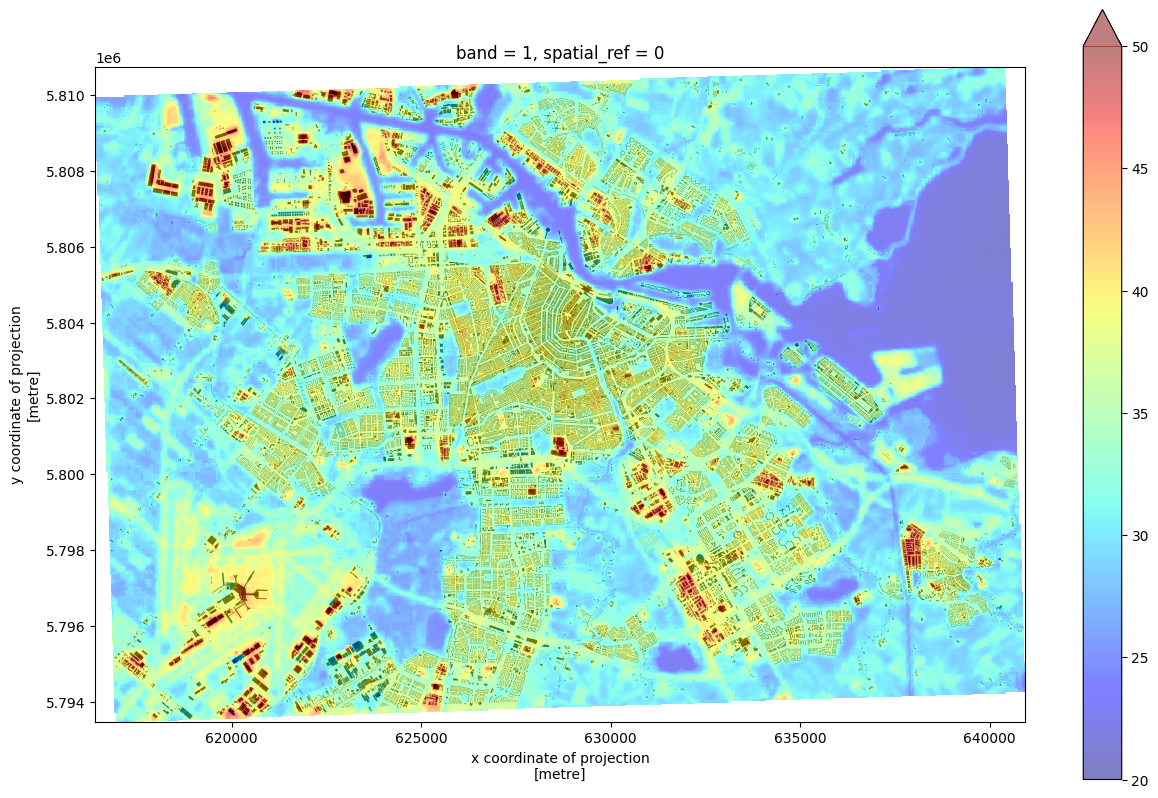

In [17]:
# Visualize

# Reproject building maps
blg_sin = blg.to_crs(lst.rio.crs)

fig, ax = plt.subplots(figsize=(15,10))
blg_sin.plot(color='black', ax=ax)
lst_clip.plot(ax=ax, alpha=0.5, cmap='jet', vmin=20, vmax=50)
#lst_clip.LST_Day_1km[0].plot(ax=gx, alpha=0.5, cmap='jet', vmin=20, vmax=45)

fig.savefig('02.png', dpi=310)

In [10]:
# Interpolate NAN values

lst_clip.interpolate_na(dim=('x'), method='linear')

lst_clip.values[0].shape

(576, 818)

In [10]:
# Take a central north-south transect as 1D data
Y = lst_clip.values[0][:,385][:,None]
#Y = lst_clip.LST_Day_1km[0].data[:,15][:,None]
X = np.array(list(range(1,len(Y)+1))).astype(float)[:,None]


In [11]:
# Clean NaN with moving average

mask = np.isnan(Y)
Y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), Y[~mask])

In [12]:
# Samples for model training

N = 10  # N_list[2]
ind = np.random.choice(len(X), N, replace=False)

X_N = X[ind]
Y_N = Y[ind]

Y_N

array([[33.53692017],
       [24.24675903],
       [35.76891479],
       [33.32158813],
       [35.56722412],
       [31.01784668],
       [36.80797729],
       [36.72252808],
       [38.01455078],
       [24.56463013]])

(20.0, 50.0)

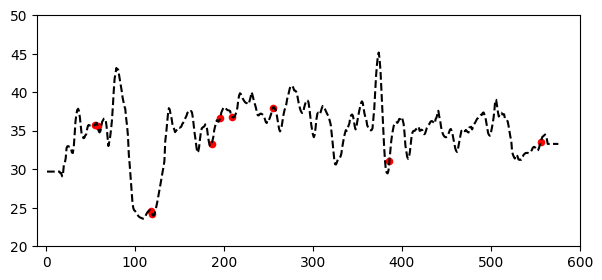

In [13]:
# Preview samples

plt.figure(figsize=(7, 3))

plot_data(X_N, Y_N)
plot_truth(X, Y, label=None)
plt.xlim([-10., 600.])
plt.ylim([20., 50.])

In [14]:
# Normalize to mean for model fitting

Y_Nmean = np.mean(Y_N)
Y_N = Y_N - Y_Nmean

print(Y_Nmean)

32.95689392089846



Name : GP regression
Objective : 32.4185389574472
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |   value  |  constraints  |  priors
  sum.rbf.variance         |     5.0  |      +ve      |        
  sum.rbf.lengthscale      |    20.0  |      +ve      |        
  sum.bias.variance        |  1225.0  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


 /home/jovyan/.local/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


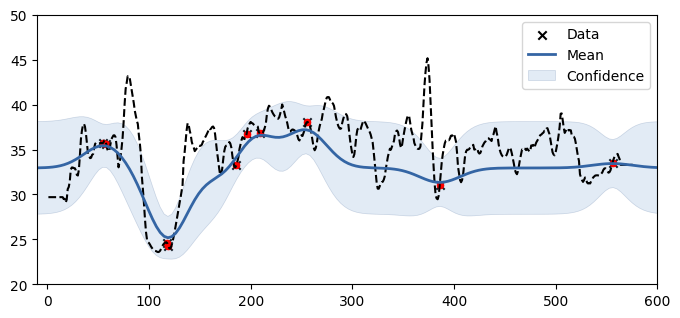

In [15]:
# Manully define and experiment with kernels

k_rbf = GPy.kern.RBF(input_dim=1, variance=5., lengthscale=20)
k_bias = GPy.kern.Bias(input_dim=1, variance=1225.)

k1 = k_rbf + k_bias
m1 = GPy.models.GPRegression(X_N,Y_N+Y_Nmean,k1)

# Plot 
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(X, Y, 'k--')
m1.plot(ax=ax)
plot_data(X_N, Y_N+Y_Nmean)
plt.xlim([-10., 600.])
plt.ylim([20., 50.])
print(m1)


Name : GP regression
Objective : 26.3929356965118
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  sum.rbf.variance         |    20.141620148246897  |      +ve      |        
  sum.rbf.lengthscale      |    17.176866334981565  |      +ve      |        
  sum.bias.variance        |    1066.5658260336968  |      +ve      |        
  Gaussian_noise.variance  |  0.010813391069239175  |      +ve      |        


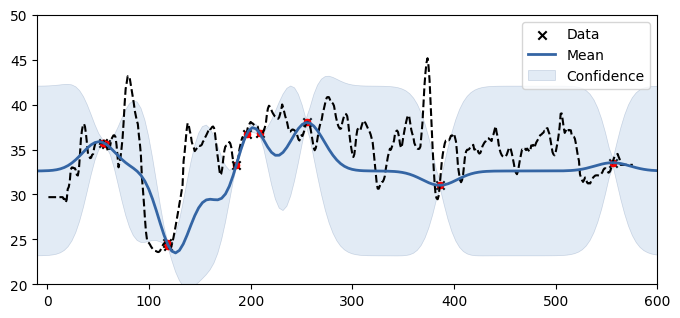

In [16]:
# Optimize the model

m1.optimize()
fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(X, Y, 'k--')
m1.plot(ax=ax)
plot_data(X_N, Y_N+Y_Nmean)
plt.xlim([-10., 600.])
plt.ylim([20., 50.])
print(m1)

(20.0, 50.0)

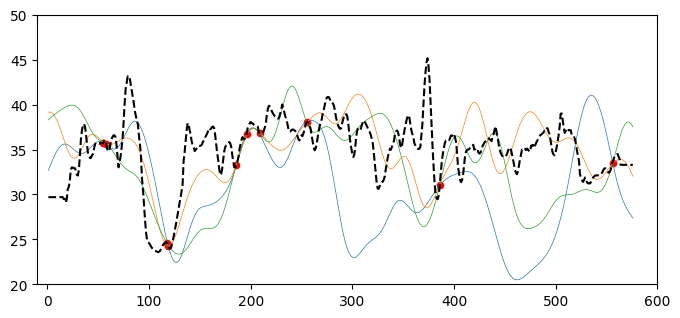

In [17]:
# Draw sample from posterior estimation

posteriorTestY = m1.posterior_samples_f(X, full_cov=True, size=3).reshape(-1,3) # Draw 3 realizations
simY, simMse = m1.predict(X)

plt.figure(figsize=(8,3.5))
plot_data(X_N, Y_N+Y_Nmean)
plt.plot(X, posteriorTestY, linewidth=.5)
plt.plot(X, Y, 'k--', markersize=4)
#plt.plot(X, simY - 3 * simMse ** 0.5, '--g', linewidth=.5)
#plt.plot(X, simY + 3 * simMse ** 0.5, '--g', linewidth=.5)
plt.xlim([-10., 600.])
plt.ylim([20., 50.])

In [83]:
# Plot the *negative log likelihood as a function of the kernel *lengthscale and *variance

# Compute *negative log likelihood
m1.unconstrain()
m1[:] = 1.0
m1.constrain_positive()

x_grid_2, y_grid_2 = np.mgrid[0.1:40.:.1, 0.1:50.:.1]

li = np.zeros_like(x_grid_2)
for i in range(x_grid_2.shape[0]):
    for j in range(x_grid_2.shape[1]):
        k2 = GPy.kern.RBF(input_dim=1, variance=x_grid_2[i, j], lengthscale=y_grid_2[i, j])
        m1 = GPy.models.GPRegression(X_N,Y_N,k2)
        li[i, j] = m1.log_likelihood() 
        print (i, j, end="\r")

In [84]:
li_ng = -li
base = 1.05
lev_exp = np.arange(np.floor(np.log(li_ng.min())/np.log(base)-2), np.ceil(np.log(li_ng.max())/np.log(base)+1))
levs = np.power(base, lev_exp)
#levs = np.flip(-levs, axis=0)
levs
#locator=ticker.LogLocator()

array([21.62349257, 22.7046672 , 23.83990056, 25.03189559, 26.28349037,
       27.59766488, 28.97754813, 30.42642554, 31.94774681, 33.54513415,
       35.22239086, 36.9835104 , 38.83268592, 40.77432022, 42.81303623,
       44.95368804, 47.20137244, 49.56144107, 52.03951312, 54.64148878,
       57.37356322, 60.24224138, 63.25435344])

Text(0.5, 1.0, 'NLL ($\\sigma, l$)')

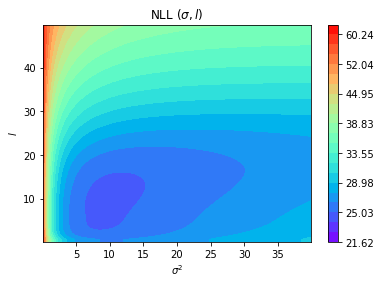

In [85]:
from matplotlib.colors import LogNorm
from matplotlib import cm

plt.contourf(x_grid_2, y_grid_2, li_ng, levels=levs, norm=LogNorm(), cmap=cm.rainbow)
#plt.gca().set_aspect('equal')
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$l$")
plt.colorbar()
plt.title(r"NLL ($\sigma, l$)")

### 03 Nyquist on 1D real-world data

100
Mean variance is: 2.8563865464341385
RMSE is: 0.9615868566780233
Mean Entropy is: 1.9436807066604236

Name : GP regression
Objective : 9.80063386628893
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     2.7864996108890256  |      +ve      |        
  rbf.lengthscale          |     2.0844074829669776  |      +ve      |        
  Gaussian_noise.variance  |  9.598284516027619e-05  |      +ve      |        


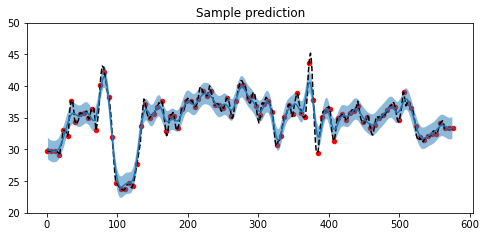

In [86]:
# Visualize a single sample predictive variance

n_size = 100 # (np.random.randint(2, 100, size=1))[0]
print(n_size)

# Sample data from a defined mean (0) and covariance
# As always to randomly draw X, this time within the defined range
ind = np.linspace(X.min(),X.max(),n_size).astype(int)-1
X_N2 = X[ind]
Y_N2 = Y[ind]

X_N2null = np.delete(X, ind)[:,None]
Y_N2null = np.delete(Y, ind)[:,None]

# !! Predict!!
k2 = GPy.kern.RBF(input_dim=1, variance=(np.random.rand(1)*30.)[0], lengthscale=(np.random.rand(1)*20.)[0])  # Arbitrarily initialized covariance/kernel function
m2 = GPy.models.GPRegression(X_N2,Y_N2-np.mean(Y_N2),k2)  # Train/fit
#m.constrain_positive('')
m2.optimize()  # Optimization
y, y_var = m2.predict(X_N2null)
y = y+np.mean(Y_N2)

# Visualize 
plt.figure(figsize=(8,3.5))
plot_data(X_N2, Y_N2)
plot_truth(X, Y, label=None)
plot_predictive(X_N2null, y, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
plt.title('Sample prediction')
plt.ylim(20., 50.)

print('Mean variance is: '+str(np.mean(y_var)))

# Simple stats for quality assessment: Uncertainty/Entropy, validation error

print('RMSE is: '+str(np.sqrt(np.mean((Y_N2null-y)**2))))
print('Mean Entropy is: '+str(np.mean(.5*(1+np.log(2*np.pi*y_var)))))

print(m)


(20.0, 50.0)

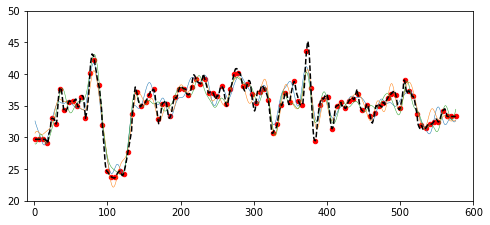

In [88]:
# Draw sample from posterior estimation

posteriorTestY = m2.posterior_samples_f(X, full_cov=True, size=3).reshape(-1,3) # Draw 3 realizations
simY, simMse = m2.predict(X)

plt.figure(figsize=(8,3.5))
plot_data(X_N2, Y_N2)
plt.plot(X, posteriorTestY+np.mean(Y_N2), linewidth=.5)
plt.plot(X, Y, 'k--', markersize=4)
#plt.plot(X, simY - 3 * simMse ** 0.5, '--g', linewidth=.5)
#plt.plot(X, simY + 3 * simMse ** 0.5, '--g', linewidth=.5)
plt.xlim([-10., 600.])
plt.ylim([20., 50.])

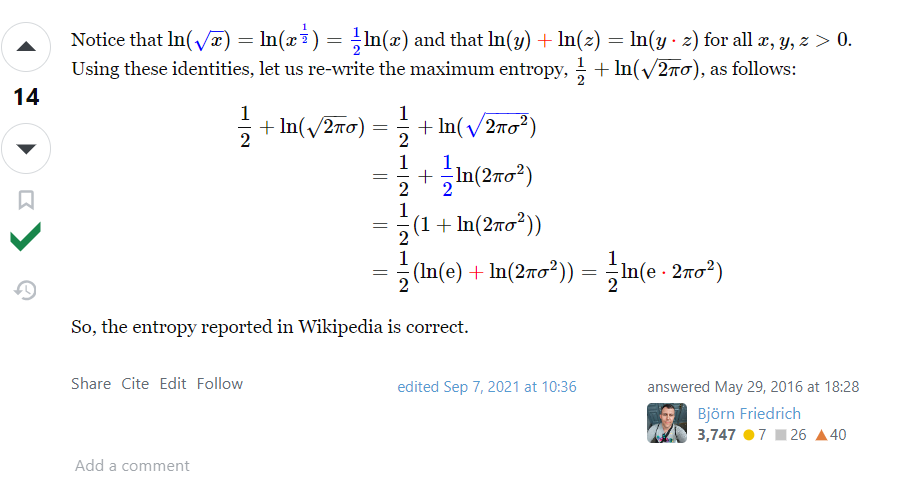

In [47]:
# Wrap-up for multiple runs: Model fit with different amount of samples

runs=20000  # Multiple runs for uncertainties analysis

len_est=[]  # As always, empty list to store estimated results
sample_size=[]
len_rmse=[]
len_etrp=[]

for i in range(runs):
    
    # Randomized inputs for each run
    n_size = (np.random.randint(2, 600, size=1))[0]
    #var_true = 9.2707
    #len_true = 4.1665
    
    # Sample data from a defined mean (0) and covariance
    # As always to randomly draw X, this time within the defined range
    ind = np.linspace(X.min(),X.max(),n_size).astype(int)-1
    X_N2 = X[ind]
    Y_N2 = Y[ind]
    
    X_N2null = np.delete(X, ind)[:,None]
    Y_N2null = np.delete(Y, ind)[:,None]
    
    # Fit
    k = GPy.kern.RBF(input_dim=1, variance=(np.random.rand(1)*30.)[0], lengthscale=(np.random.rand(1)*20.)[0])  # Arbitrarily initialized covariance/kernel function
    m = GPy.models.GPRegression(X_N2,Y_N2-np.mean(Y_N2),k)  # Train/fit
    #m.constrain_positive('')
    m.optimize()  # Optimization
    
    # !! Predict!!
    #m.constrain_positive('')
    y, y_var = m.predict(X_N2null)
    y = y+np.mean(Y_N2)
    
    len_est.append(m.rbf.lengthscale[0])
    sample_size.append(n_size)
    
    # Simple stats for quality assessment: Uncertainty/Entropy, validation error
    len_rmse.append(np.sqrt(np.mean((Y_N2null-y)**2)))
    len_etrp.append(np.mean(.5*(1+np.log(2*np.pi*y_var))))
    
    print (i, end="\r")
    
uvxy = np.stack([len_est,sample_size, len_rmse, len_etrp])
np.save('20000run_equalspaced_randominit.npy', uvxy)

 /usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:Mean of empty slice.
 /usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars


 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


In [4]:
uvxy = np.load('20000run_equalspaced_randominit.npy')
len_est, sample_size, len_rmse, len_etrp = uvxy[0], uvxy[1], uvxy[2], uvxy[3]


(-10.0, 600.0)

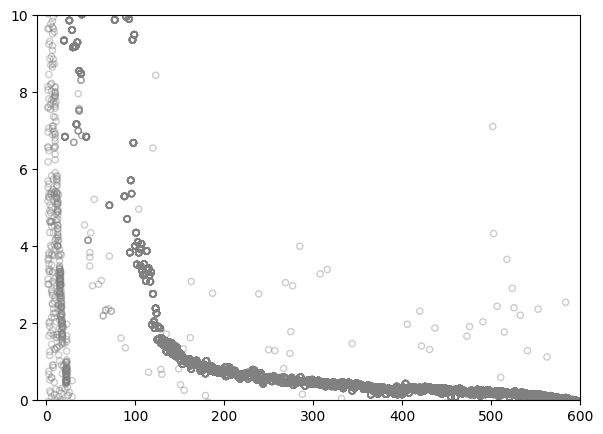

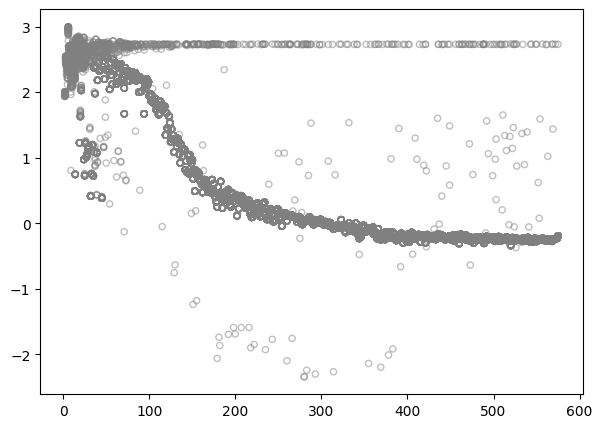

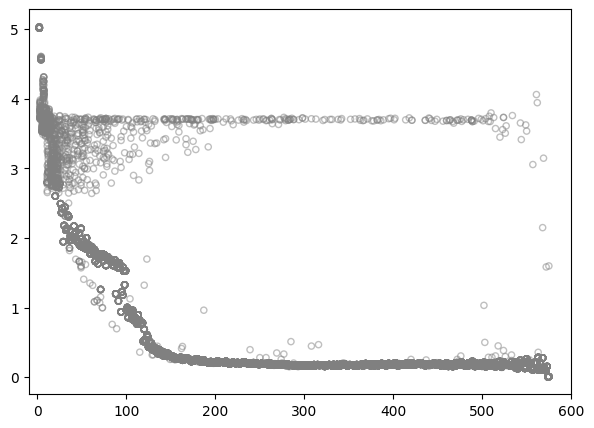

In [7]:
# Visualize estimated lengthscale 
plt.figure(figsize=(7,5))
plt.scatter(np.array(sample_size), np.array(len_est)-4.1, s=20., marker='o', alpha=0.4, edgecolors='grey', facecolors='none')
plt.xlim([-10., 600.])
plt.ylim([0., 10.])

# Visualize error-entropy correlation
plt.figure(figsize=(7,5))
plt.scatter(np.array(sample_size), np.array(len_etrp), s=20., marker='o', alpha=0.5, edgecolors='grey', facecolors='none')
#plt.xlim([-10., 600.])
#plt.ylim([0., 10.])

# Visualize sample size-error correlation
plt.figure(figsize=(7,5))
plt.scatter(np.array(sample_size), np.array(len_rmse), s=20., marker='o', alpha=0.5, edgecolors='grey', facecolors='none')
plt.xlim([-10., 600.])
#plt.ylim([0., 10.])
        

In [374]:
'''
# How many time points are needed i,e., Sampling Frequency
samplingFrequency = 100;

# At what intervals time points are sampled
samplingInterval = 1 / samplingFrequency;

# Begin time period of the signals
beginTime = 0;

# End time period of the signals
endTime = 10; 

# Frequency of the signals
signal1Frequency = 4;
signal2Frequency = 7;

# Time points
time = np.arange(beginTime, endTime, samplingInterval)

# Create two sine waves
amplitude1 = np.sin(2*np.pi*signal1Frequency*time)
amplitude2 = np.sin(2*np.pi*signal2Frequency*time)

amplitude = amplitude1 + amplitude2
'''

In [49]:
# Double check frequency domain distribution through Fourier transformation

samplingFrequency = 1
location = X.ravel()
amplitude = Y.ravel()
amplitude = amplitude-np.mean(amplitude)

In [50]:
# Frequency domain representation
fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude
fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency
tpCount = len(amplitude)
values = np.arange(int(tpCount/2))
timePeriod = tpCount/samplingFrequency
frequencies = values/timePeriod

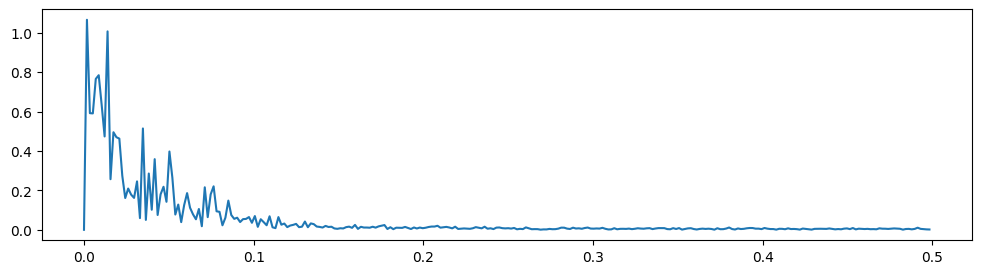

In [51]:
plt.figure(figsize=(12,3))
plt.plot(frequencies, abs(fourierTransform))
#plt.xlim([-2., 50.])

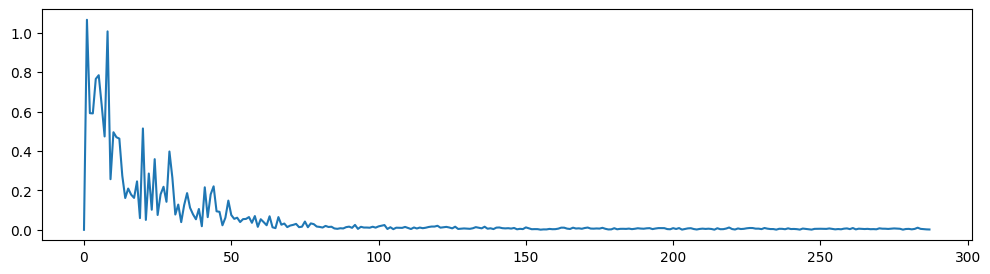

In [52]:
# Simple version without standardizing the spatial index

ff = np.fft.fft(amplitude/576)
ff = ff[range(int(len(amplitude)/2))]

plt.figure(figsize=(12,3))
plt.plot(abs(ff))

### 04 Nyquist on 2D real-world data

Mean temperature is: 35.84845962819272
The size of the map is (180, 230)


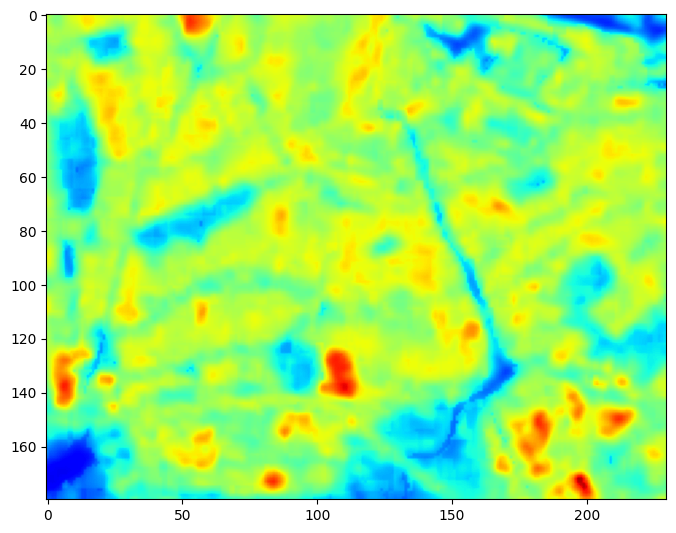

In [11]:
# Entire image value quanlity check

Y2 = lst_clip.interpolate_na(dim=('x'), method='linear')
Y2 = lst_clip.values[0]
Y2 = Y2[200:380, 300:530]

print('Mean temperature is: '+str(np.mean(Y2)))

fig, ax = plt.subplots(figsize=(8,11))
plt.imshow(Y2, cmap='jet', vmin=20, vmax=50)

print("The size of the map is " + str(Y2.shape))
r, c = Y2.shape


In [12]:
# Map spatial index as pixel rows and columns

ny, nx = (Y2.shape[0], Y2.shape[1])
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
xv, yv = np.meshgrid(x, y)

In [13]:
# !! Zero mean

print('The overall mean of the image is: '+str(Y2.mean()))
Y2 = Y2-Y2.mean()

The overall mean of the image is: 35.84845962819272


In [14]:
# Combine index and LST value

XYZ = np.hstack([xv.reshape(-1,1), yv.reshape(-1,1), Y2.reshape(-1,1)])

# Random samples for GP inference

XYZ_sub = XYZ[np.random.choice(len(XYZ), 2000, replace=False),:]

In [24]:
# Quick inference

# Samples
XY_N = XYZ_sub[:,:2]
Z_N = XYZ_sub[:,2][:,None]

# Define kernel
k_2d = GPy.kern.RBF(input_dim=2, ARD=True)

# Create simple GP model
m_2d = GPy.models.GPRegression(XY_N,Z_N,k_2d)
m_2d.optimize()

 C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


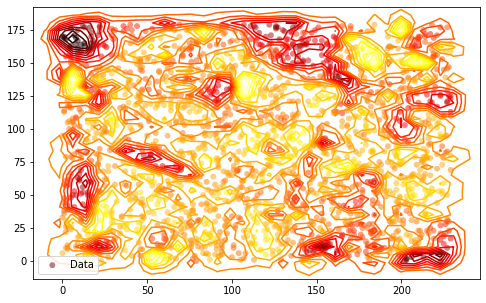

In [25]:
fig, ax = plt.subplots(figsize=(8,5))
_ = m_2d.plot(ax=ax)

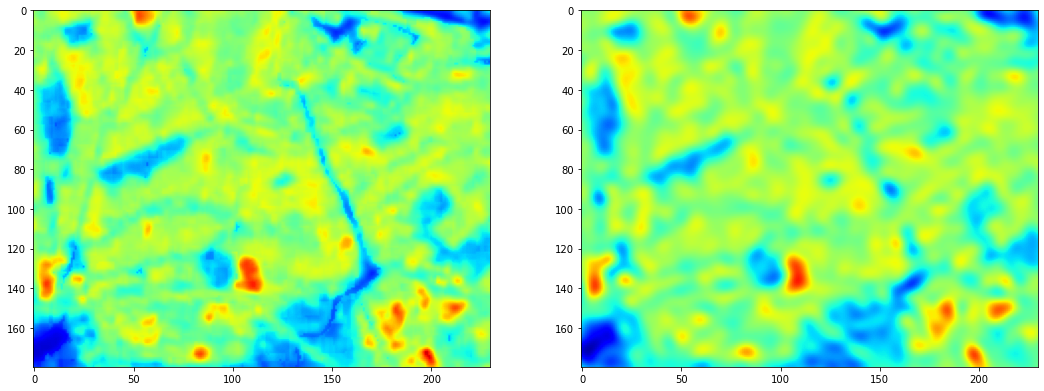

In [26]:
# Prediction

Z_pred, Z_var = m_2d.predict(XYZ[:,:2])[0]

# Comparison

plt.figure(figsize=(18, 11))
plt.subplots_adjust(hspace=0.2)

plt.subplot(1, 2, 1)
plt.imshow(Y2, cmap='jet', vmin=-15, vmax=15)

plt.subplot(1, 2, 2)
plt.imshow(Z_pred.reshape(Y2.shape[0], Y2.shape[1]), cmap='jet', vmin=-15, vmax=15)

In [28]:
# Posterior sampling

#posteriorTest = m_2d.posterior_samples_f(XYZ[:,:2], full_cov=True, size=1).reshape(Y2.shape[0], Y2.shape[1]) # Size is the number of posterior samples
#simY, simMse = m_2d.predict(XYZ[:,:2])

plt.figure(figsize=(18, 11))
plt.subplots_adjust(hspace=0.2)

plt.subplot(1, 2, 1)
plt.imshow(Y2, cmap='jet', vmin=20, vmax=50)

plt.subplot(1, 2, 2)
plt.imshow(posteriorTest.reshape(Y2.shape[0], Y2.shape[1]), cmap='jet', vmin=20, vmax=50)

MemoryError: Unable to allocate 12.8 GiB for an array with shape (41400, 41400) and data type float64

In [ ]:
simMse.shape

#### 2D statistics with multiple run!! (zero mean!)

In [15]:
# A simple function for 2D GP estimation to save RAM

def gp2d(coord, z, coordnew):
    # Define kernel
    k_2d = GPy.kern.RBF(input_dim=2, ARD=True)

    # Create simple GP model
    m_2d = GPy.models.GPRegression(coord,z,k_2d)
    m_2d.optimize()

    # Prediction
    Z_pred, Z_var = m_2d.predict(coordnew)
    
    return Z_pred, Z_var, m_2d.rbf.lengthscale

In [ ]:
# Sampling on 2D space!

n_size = 93

len_est=[]  # As always, empty list to store estimated results
sample_size_rc=[]
len_rmse=[]
len_etrp=[]

stp = 2
min_sample = 10
for i in range(min_sample, n_size, stp):
    for j in range(min_sample, n_size, stp):
        ind_c = np.linspace(1, Y2.shape[1], i).astype(int)-1
        ind_r = np.linspace(1, Y2.shape[0], j).astype(int)-1
        
        ind = ind_c
        for k in range(len(ind_r)-1):
            ind = np.concatenate((ind, ind_c + ind_r[k+1]*Y2.shape[1]))
        
        # Random samples for GP inference
        XYZ_sub = XYZ[ind,:]
        XYZ_val = np.delete(XYZ, ind, axis=0)

        # Quick inference

        # Samples
        XY_N = XYZ_sub[:,:2]
        Z_N = XYZ_sub[:,2][:,None]

        # Estimation
        Z_pred, Z_var, len2d = gp2d(XY_N,Z_N, XYZ_val[:,:2])
        length = (len2d[0], len2d[1])
        
        len_est.append(length)
        sample_size_rc.append((j, i))

        # Simple stats for quality assessment: Uncertainty/Entropy, validation error
        len_rmse.append(np.sqrt(np.mean((XYZ_val[:,2]-Z_pred)**2)))
        len_etrp.append(np.mean(.5*(1+np.log(2*np.pi*Z_var))))

        print ('Epoch: '+str(i)+','+str(j), end="\r")
        
        if i>50 and j>50:
            uvxy = [len_est, sample_size_rc, len_rmse, len_etrp]
            with open('90*90run_equalspaced_randominit_2d.pkl', 'wb') as f:
                pickle.dump(uvxy, f)
        
# Save
uvxy = [len_est, sample_size_rc, len_rmse, len_etrp]
with open('90*90run_equalspaced_randominit_2d.pkl', 'wb') as f:
    pickle.dump(uvxy, f)
        

 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide


 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/jovyan/.local/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


In [4]:
# Load
uvxy = pickle.load( open( '90_90run_equalspaced_randominit_2d.pkl', "rb" ) )

len_est, sample_size_rc, len_rmse, len_etrp = uvxy[0], uvxy[1], uvxy[2], uvxy[3]

In [5]:
len(len_etrp)

1385

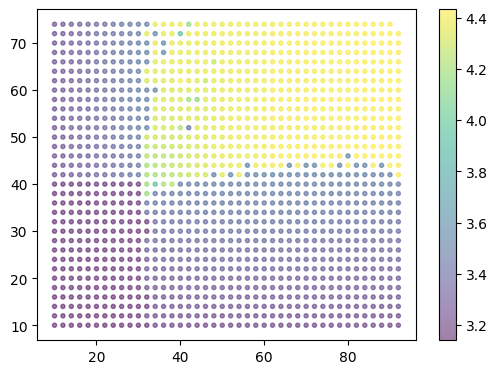

In [13]:
plt.figure(figsize=(6.1, 4.3))
plt.scatter(np.array(sample_size_rc)[:,0], np.array(sample_size_rc)[:,1], c=np.array(len_rmse), marker='.', alpha=0.5)
plt.colorbar()

In [9]:
# Visualize estimated lengthscale 
plt.figure(figsize=(7,5))
plt.scatter(np.array(sample_size), np.array(len_est), s=20., marker='o', alpha=0.4, edgecolors='grey', facecolors='none')
plt.xlim([-10., 600.])
plt.ylim([0., 10.])

# Visualize error-entropy correlation
plt.figure(figsize=(7,5))
plt.scatter(np.array(len_rmse), np.array(len_etrp), s=20., marker='o', alpha=0.5, edgecolors='grey', facecolors='none')
#plt.xlim([-10., 600.])
#plt.ylim([0., 10.])

# Visualize sample size-error correlation
plt.figure(figsize=(7,5))
plt.scatter(np.array(sample_size), np.array(len_rmse), s=20., marker='o', alpha=0.5, edgecolors='grey', facecolors='none')
plt.xlim([-10., 600.])
#plt.ylim([0., 10.])


NameError: name 'sample_size' is not defined

<Figure size 700x500 with 0 Axes>

In [21]:
# Using the entire image to double check frequency domain distribution through Fourier transformation

samplingFrequency2 = 1
#location = X
amplitude2 = Y2
amplitude2 = amplitude2-np.mean(amplitude2)

In [22]:
# Frequency domain representation

ft2 = np.fft.ifftshift(amplitude2)
ft2 = np.fft.fft2(ft2)/(r*c)
ft2 = np.fft.fftshift(ft2)

#fourierTransform2 = np.fft.fft(amplitude2)           # Normalize amplitude
#fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

values_r = np.arange(int(r))-int(r/2)
values_c = np.arange(int(c))-int(c/2)

frequencies_r = values_r/r
frequencies_c = values_c/c


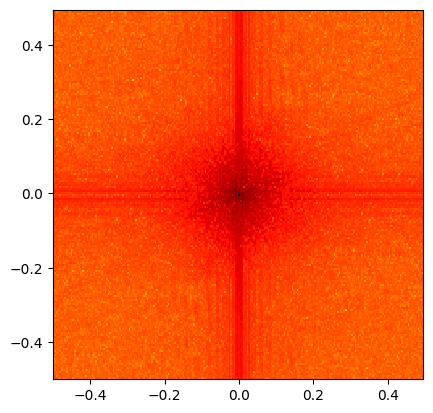

In [23]:
plt.imshow(np.log(abs(ft2)), cmap='jet', interpolation='none', extent=[frequencies_c.min(),frequencies_c.max(),frequencies_r.min(),frequencies_r.max()])

### 05 Nyquist on 2D real-world data WITH covariates

In [16]:
# Plot point in 3d
def plotPt(x, y):
    # Plot 3d random points
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlim3d(np.min(x[:,0]),np.max(x[:,0]))
    ax.set_ylim3d(np.min(x[:,1]),np.max(x[:,1]))
    ax.set_zlim3d(np.min(y),np.max(y))
    ax.scatter(x[:,0], x[:,1], y)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Y')
    plt.show()
    return None


# Show dummy grid dataset
def showGrid(X, Y, r, c):  # r and c are Rows and columns
    x1, x2 = X.reshape(r,c,2)[:,:,0], X.reshape(r,c,2)[:,:,1]
    Y = Y.reshape(r,c)
    print('Surface dimensions in x1, x2, and y are ', x1.shape, x2.shape, Y.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(np.min(x1),np.max(x1))
    ax.set_ylim3d(np.min(x2),np.max(x2))
    ax.set_zlim3d(np.min(Y),np.max(Y))
    ax.plot_surface(x1, x2, Y)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Y')
    plt.show()
    return None


# Kernel options
def kern():
    kg = GPy.kern.RBF(input_dim=2, ARD=True)
    #kb = GPy.kern.Bias(input_dim=2)
    k = kg #+ kb
    k.plot()
    return (k)


# Model specification
def model(X, Y):
    k = kern()  # Kernel
    
    m = GPy.models.GPRegression(X,Y,k)  # Specify model, normalizer=True
    #m.sum.bias.variance.constrain_bounded(1e-3,1e5)
    #m.sum.rbf.variance.constrain_bounded(1e-3,1e5)
    #m.rbf.variance.constrain_bounded(1e-3,1e5)
    #m.sum.rbf.lengthscale.constrain_bounded(.1,200.)
    #m.rbf.lengthscale.constrain_bounded(.1,200.)
    #m.Gaussian_noise.variance.constrain_fixed(1e-3, 1e-1)
    
    m.randomize()  # Random initialization
    m.optimize()  # Optimization
    m.plot()
    return (m)


# GP realization of dummy function-based dataset as ground truth GP
def gtGP(X, Y, r, c, s):
    rr, cc = int(r*s), int(c*s)  # Rows and columns with scaled density
    m = model(X, Y)  # Train the model over dummy grid dataset
    print(m)
    
    xg1 = np.linspace(X[:,0].min(),X[:,0].max(),rr)
    xg2 = np.linspace(X[:,1].min(),X[:,1].max(),cc)

    Xp = np.zeros((xg1.size * xg2.size,2))
    for i,x1 in enumerate(xg1):
        for j,x2 in enumerate(xg2):
            Xp[i+xg1.size*j,:] = [x1,x2]
    # Draw dense GP approximation to the dummy through trained model
    Yp = m.predict(Xp)[0]
    return (Xp, Yp, m)



Surface dimensions in x1, x2, and y are  (180, 230) (180, 230) (180, 230)


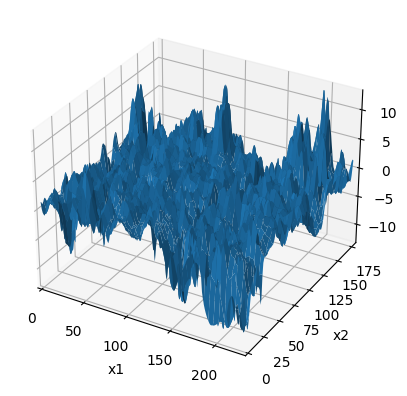

In [17]:
# real-world data into columns and visualization

X2, Y2 = XYZ[:,:2], XYZ[:,2][:,None]
showGrid(X2, Y2, r, c)

<Figure size 640x480 with 0 Axes>

Surface dimensions in x1, x2, and y are  (180, 230) (180, 230) (180, 230)


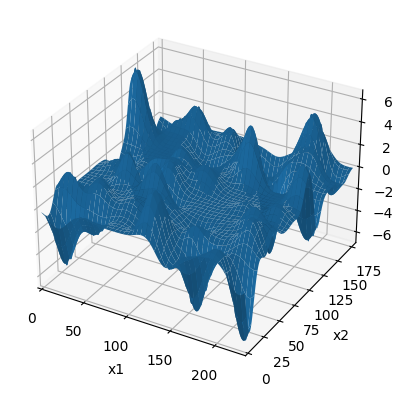

In [18]:
# Sample fit through GP (parameters are var and lengthscale)

# Random samples for GP inference

XYZ_sub = XYZ[np.random.choice(len(XYZ), 100, replace=False),:]
plotPt(XYZ_sub[:,:2], XYZ_sub[:,2][:,None])

Z_pred, Z_var, len2d = gp2d(XYZ_sub[:,:2], XYZ_sub[:,2][:,None], X2)
showGrid(X2, Z_pred, r, c)


#### 2D Coregionalization

In [19]:
# Linearly correlated covariate through linear transformation
def linCov(X,Y):
    scale = np.linspace(-1,1,1)
    for s in scale:
        print('Scale Y by ', s)
        Ys = Y*s
        showGrid(X, Ys)
    return (X, Ys)


# Simple random/white noise controlled by variance and sparsity
def noiseCov(X, Y, r, c, var, spar):
    if var==0 or spar==0:
        Ynoise = 0
    else:
        # Grid same to the original X
        xg1 = np.linspace(X[:,0].min(), X[:,0].max(), r)
        xg2 = np.linspace(X[:,1].min(), X[:,1].max(), c)
        grid_x, grid_y = np.meshgrid(xg1, xg2)
        
        # Grid scaled by sparsity parameter to create random/white noise
        pix_size = np.ptp(X[:,0])/np.sqrt(len(X))  # Original pixel size
        s = spar/pix_size  # Scale factor as number of pixels
        xxg1 = np.linspace(X[:,0].min(), X[:,0].max(), int(r/s))
        xxg2 = np.linspace(X[:,1].min(), X[:,1].max(), int(c/s))
        grid_xx, grid_yy = np.meshgrid(xxg1, xxg2)
        
        ind = np.array([grid_xx.ravel(), grid_yy.ravel()]).T
        Ynoise = np.sqrt(var)*np.random.randn(ind.shape[0], 1)
        Ynoise = interpolate.griddata(ind, Ynoise, (grid_x, grid_y), method='linear')
        Ynoise = Ynoise.reshape(-1,1)
    showGrid(X, Y+Ynoise, r, c)
    return (X, Y+Ynoise)


# Learn coregionalization model
def coregionGP(X0, Y0, X1, Y1):
#    X0widx = np.c_[X0,np.ones(X0.shape[0])*0]  # Add a column of coregionalized index through np.c_
#    X1widx = np.c_[X1,np.ones(X1.shape[0])*1]
#    X = np.r_[X0widx,X1widx]  # Row-wise merge all X through np.r_
#    Y = np.r_[Y0,Y1]
#    kern = GPy.kern.RBF(input_dim=1)**GPy.kern.Coregionalize(input_dim=2,output_dim=2, rank=1)
#    m = GPy.models.GPCoregionalizedRegression(X,Y,kern)

    X = np.array([X0, X1])  # Prepare X and Y for Intrinsic Coregionalization Model (ICM)
    Y = np.array([Y0, Y1])
                  
    K = GPy.kern.RBF(2, ARD=True)  # 2-D Radial Basis Function
    icm = GPy.util.multioutput.ICM(input_dim=2,num_outputs=2,kernel=K)
    m = GPy.models.GPCoregionalizedRegression(X,Y,kernel=icm)    
    m.optimize()
    #print(m)
    W = m.ICM.B.W
    B = W*W.T  # Covariance matrix
    Bnorm = (B/np.sqrt(np.diag(B))).T/np.sqrt(np.diag(B))  # Correlation as normalized covariance matrix
    #print('The correlation matrix is \n', Bnorm)
    return (m, Bnorm)



Surface dimensions in x1, x2, and y are  (180, 230) (180, 230) (180, 230)


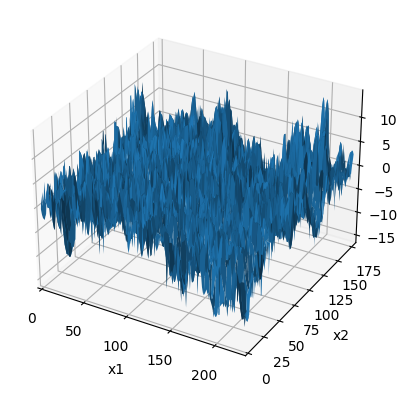

Surface dimensions in x1, x2, and y are  (180, 230) (180, 230) (180, 230)


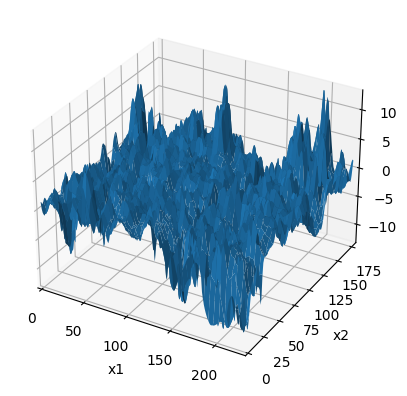

In [22]:
XX, YY = noiseCov(X2, Y2, r, c, np.var(Z_pred)*4., 5)

showGrid(X2, Y2, r, c)

In [23]:
# Simple check through Pearson correlation

print(pearsonr(Y2.ravel(), YY.ravel()))

(0.8157476570439928, 0.0)


In [24]:
XYZZ = np.concatenate((XYZ,YY), axis=1)

XYZZ.shape

(41400, 4)

In [25]:
print(pearsonr(XYZZ[:,2], XYZZ[:,3]))

(0.8157476570439928, 0.0)


In [26]:
# Random samples for GP inference
ind = np.random.choice(len(XYZZ), 500, replace=False)

XYZZ_sub = XYZZ[ind,:]
XYZZ_val = np.delete(XYZZ, ind, axis=0)

# Further split two subsets as joint Gaussian processes
np.random.shuffle(XYZZ_sub)
split_ratio = .4
XYZZ_sub1, XYZZ_sub2 = XYZZ_sub[:int(len(XYZZ_sub)*split_ratio),:], XYZZ_sub[int(len(XYZZ_sub)*split_ratio):,:]

# Samples
#XY_N = XYZZ_sub[:,:2]
#Z_N = XYZZ_sub[:,2][:,None]


In [27]:
# Quick Multi-Task Gaussian Process inference of the model

mCoreg, Bnorm = coregionGP(XYZZ_sub1[:,:2], XYZZ_sub1[:,2][:,None], XYZZ_sub2[:,:2], XYZZ_sub2[:,3][:,None])


 /tmp/ipykernel_1444/947588941.py:45: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 /tmp/ipykernel_1444/947588941.py:46: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Surface dimensions in x1, x2, and y are  (180, 230) (180, 230) (180, 230)


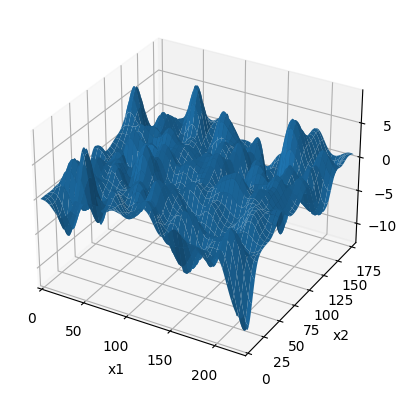

In [28]:
# Prediction

# Prediction through optimized model
Xnew = np.hstack([X2,np.zeros_like(Y2)])  # Using existing Xp as new location for prediction on sparse process
noise_dict = {'output_index':Xnew[:,-1].astype(int)}  # Indicate noise model to be used
Y_hat = mCoreg.predict(Xnew,Y_metadata=noise_dict)[0]

# Visualize
showGrid(X2, Y_hat, r, c)

In [29]:
# Validating

np.sqrt(np.square(np.subtract(XYZZ_val[:,2][:,None], np.delete(Y_hat, ind, axis=0))).mean())


2.107805053067485

#### 2D Coregionalization **multiple runs**

In [30]:
# Sampling on 2D space!

n_size = 93

sample_size_rc=[]
len_rmse=[]
len_etrp=[]

stp = 2
min_sample = 70
for i in range(min_sample, n_size, stp):
    for j in range(min_sample, n_size, stp):
        ind_c = np.linspace(1, c, i).astype(int)-1
        ind_r = np.linspace(1, r, j).astype(int)-1
        
        ind = ind_c
        for k in range(len(ind_r)-1):
            ind = np.concatenate((ind, ind_c + ind_r[k+1]*c))

        XYZZ_sub = XYZZ[ind,:]
        XYZZ_val = np.delete(XYZZ, ind, axis=0)

        # Further split two subsets as joint Gaussian processes
        np.random.shuffle(XYZZ_sub)
        split_ratio = .4
        XYZZ_sub1, XYZZ_sub2 = XYZZ_sub[:int(len(XYZZ_sub)*split_ratio),:], XYZZ_sub[int(len(XYZZ_sub)*split_ratio):,:]
            
        # Quick Multi-Task Gaussian Process inference of the model
        mCoreg, Bnorm = coregionGP(XYZZ_sub1[:,:2], XYZZ_sub1[:,2][:,None], XYZZ_sub2[:,:2], XYZZ_sub2[:,3][:,None])

        # Prediction through optimized model
        Xnew = np.hstack([X2,np.zeros_like(Y2)])  # Using existing Xp as new location for prediction on sparse process
        noise_dict = {'output_index':Xnew[:,-1].astype(int)}  # Indicate noise model to be used
        Y_hat, Y_var = mCoreg.predict(Xnew,Y_metadata=noise_dict)

        # Store
        sample_size_rc.append((j, i))

        # Simple stats for quality assessment: Uncertainty/Entropy, validation error
        len_rmse.append(np.sqrt(np.square(np.subtract(XYZZ_val[:,2][:,None], np.delete(Y_hat, ind, axis=0))).mean()))
        len_etrp.append(np.mean(.5*(1+np.log(2*np.pi*Y_var))))

        print ('Epoch: '+str(i)+','+str(j), end="\r")
        
        if i>50 and j>50:
            uvxy = [sample_size_rc, len_rmse, len_etrp]
            with open('ex90_90run_coregionalized_equalspaced_randominit_2d.pkl', 'wb') as f:
                pickle.dump(uvxy, f)
        
# Save
uvxy = [sample_size_rc, len_rmse, len_etrp]
with open('ex90_90run_coregionalized_equalspaced_randominit_2d.pkl', 'wb') as f:
    pickle.dump(uvxy, f)
        

 /tmp/ipykernel_1444/947588941.py:45: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
 /tmp/ipykernel_1444/947588941.py:46: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [57]:
# Load
uvxy = pickle.load( open( '90_90run_coregionalized_equalspaced_randominit_2d.pkl', "rb" ) )

sample_size_rc, len_rmse, len_etrp = uvxy[0], uvxy[1], uvxy[2]


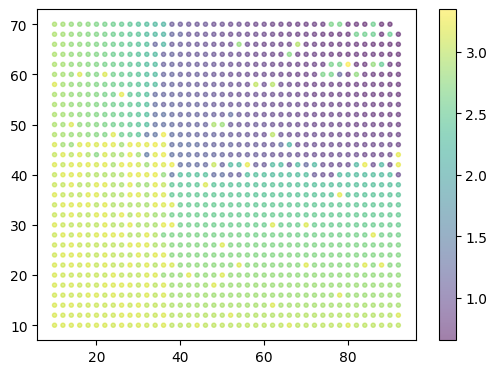

In [58]:
plt.figure(figsize=(6.1, 4.3))
plt.scatter(np.array(sample_size_rc)[:,0], np.array(sample_size_rc)[:,1], c=np.array(len_rmse), marker='.', alpha=0.5)
plt.colorbar()


In [33]:
uvxy1 = pickle.load( open( '90_90run_coregionalized_equalspaced_randominit_2d.pkl', "rb" ) )
uvxy2 = pickle.load( open( 'ex90_90run_coregionalized_equalspaced_randominit_2d.pkl', "rb" ) )

In [34]:
sample_size_rc1, len_rmse1, len_etrp1 = uvxy1[0], uvxy1[1], uvxy1[2]
sample_size_rc2, len_rmse2, len_etrp2 = uvxy2[0], uvxy2[1], uvxy2[2]

In [46]:
sample_size_rc, len_rmse, len_etrp = sample_size_rc1[:1292]+sample_size_rc2, len_rmse1[:1292]+len_rmse2, len_etrp1[:1292]+len_etrp2